# Import and Setup

In [1]:
import os
import sys
import time
import math
import random
from datetime import datetime

In [2]:
import collections
from collections import Counter
from importlib import reload

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [5]:
import torch
from torch import nn
from torch import optim
from torch.functional import F
from torch.utils.data import DataLoader

In [6]:
import training

## Load data

In [7]:
data_df = pd.read_csv("./Cleaned_data.csv")
data_df.columns = ["id", "temp", "humidity", "pm25", "date", "time", "monthday", "month",
    "year", "weekday_int", "weekday", "week_day_end", "hour", "am_pm", "air_quality"]
                      
data_df.head(3)

,id,temp,humidity,pm25,date,time,monthday,month,year,weekday_int,weekday,week_day_end,hour,am_pm,air_quality
0,198,89,50,40.78,2021-07-26,16:45:59,26,July,2021,0,Monday,Weekdays,16,PM,Unhealthy
1,199,89,50,40.09,2021-07-26,16:48:03,26,July,2021,0,Monday,Weekdays,16,PM,Unhealthy
2,200,89,50,37.93,2021-07-26,16:49:59,26,July,2021,0,Monday,Weekdays,16,PM,Unhealthy


**Clean data**

Remove redundant and un-necessary columns

    - id : not needed as it does not provide any meaningful information.
    - month : only 4 months were represented, so it's best to ignore it.
    - year : only 1 year was represented, so it's best to ignore it.
    - weekday_int : already implied in the weekday and also not a suitable representation for categorical data.
    - week_day_end : already implied in the weekday.
    - am_pm : already implied in the hour.

In [8]:
clean_data_df = data_df.drop(
    columns=["id", "month", "year", "weekday_int", "week_day_end", "am_pm"],
    errors="ignore")
clean_data_df.head(3)

,temp,humidity,pm25,date,time,monthday,weekday,hour,air_quality
0,89,50,40.78,2021-07-26,16:45:59,26,Monday,16,Unhealthy
1,89,50,40.09,2021-07-26,16:48:03,26,Monday,16,Unhealthy
2,89,50,37.93,2021-07-26,16:49:59,26,Monday,16,Unhealthy


Convert temperature from Fahrenheit to Kelvin

In [9]:
fahren_to_kelvin = lambda x: (5/9*(x-32))+273
clean_data_df.temp = [round(fahren_to_kelvin(x), 2) for x in data_df.temp]

Merge date and time column to datetime column of type datetime

In [10]:
to_datetime = lambda date_str, time_str: datetime.strptime(
    "{} {}".format(date_str, time_str), "%Y-%m-%d %H:%M:%S")
clean_data_df["datetime"] = [to_datetime(*r) for r in data_df[["date", "time"]].values]
clean_data_df = clean_data_df.drop(columns=["date", "time"], errors="ignore")

Add new column, `time_delta`, which is the time change in hours

In [11]:
time_change = lambda col, curr_ix, prev_ix: (col[curr_ix] - col[prev_ix]).seconds
clean_data_df["time_delta"] = [time_change(clean_data_df["datetime"], i, i-1)/(60*60)\
    if i != 0 else 0.0 for i in range(len(clean_data_df))]

In [12]:
clean_data_df.head(3)

,temp,humidity,pm25,monthday,weekday,hour,air_quality,datetime,time_delta
0,304.67,50,40.78,26,Monday,16,Unhealthy,2021-07-26 16:45:59,0.000000
1,304.67,50,40.09,26,Monday,16,Unhealthy,2021-07-26 16:48:03,0.034444
2,304.67,50,37.93,26,Monday,16,Unhealthy,2021-07-26 16:49:59,0.032222


**Analysis**

In [13]:
clean_data_df.columns

Index(['temp', 'humidity', 'pm25', 'monthday', 'weekday', 'hour',
       'air_quality', 'datetime', 'time_delta'],
      dtype='object')

Correlation

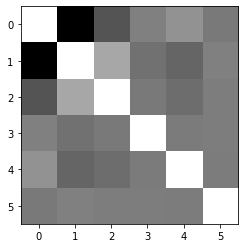

In [14]:
plt.imshow(clean_data_df.corr(), cmap=plt.cm.gray)

In [15]:
print({x: len(clean_data_df.loc[:, x].unique()) for x in clean_data_df.columns})

{'temp': 38, 'humidity': 61, 'pm25': 13423, 'monthday': 31, 'weekday': 7, 'hour': 24, 'air_quality': 5, 'datetime': 56052, 'time_delta': 529}


In [16]:
clean_data_df.describe()

,temp,humidity,pm25,monthday,hour,time_delta
count,56052.000000,56052.000000,56052.000000,56052.000000,56052.000000,56052.000000
mean,302.345136,65.117766,54.391926,15.534450,11.685988,0.038836
std,2.399648,8.550730,42.205997,9.000277,6.842374,0.161113
min,294.110000,29.000000,0.780000,1.000000,0.000000,0.000000
25%,300.780000,61.000000,30.170000,8.000000,6.000000,0.033333
50%,301.890000,68.000000,41.450000,15.000000,12.000000,0.033333
75%,303.560000,71.000000,61.190000,23.000000,18.000000,0.033611
max,315.220000,89.000000,568.080000,31.000000,23.000000,23.910556


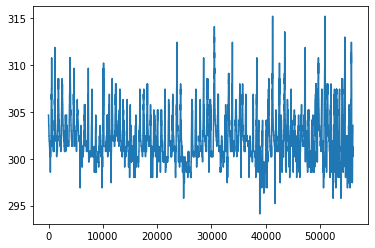

In [17]:
plt.plot(clean_data_df.temp)

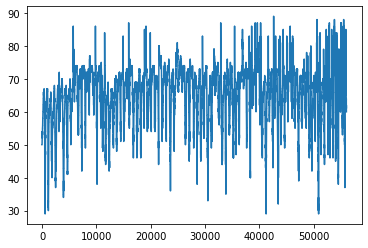

In [18]:
plt.plot(clean_data_df.humidity)

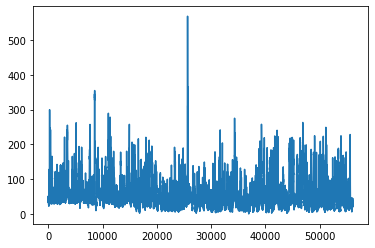

In [20]:
plt.plot(clean_data_df.pm25)

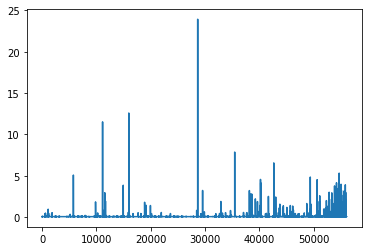

In [21]:
plt.plot(clean_data_df.time_delta)

## Build datasets

Split data

In [77]:
data_len = len(clean_data_df)

train_df = clean_data_df[:int(0.90*data_len)].copy()
test_df = clean_data_df[int(0.90*data_len):].copy()

print(len(clean_data_df))
print(len(train_df))
print(len(test_df))

56052
50446
5606


Normalize `temp, humidity, pm25` and save in new columns

    
- Tried using StandardScaler at first, but the model's perfomance was terrible.
- Normalizing `time_delta` also did not produce better results.

In [78]:
scaler = MinMaxScaler()# StandardScaler()

In [79]:
train_df["n_temp"], train_df["n_humidity"], train_df["n_pm25"] = [0., 0., 0.]
train_df[["n_temp", "n_humidity", "n_pm25"]] = scaler.fit_transform(train_df[["temp", "humidity", "pm25"]])

test_df["n_temp"], test_df["n_humidity"], test_df["n_pm25"] = [0., 0., 0.]
test_df[["n_temp", "n_humidity", "n_pm25"]] = scaler.transform(test_df[["temp", "humidity", "pm25"]])

In [80]:
print(scaler.data_max_)
print(scaler.data_min_)
print(scaler.data_range_)

[315.22  89.   568.08]
[294.11  29.     0.78]
[ 21.11  60.   567.3 ]


In [81]:
train_df.head(2)

,temp,humidity,pm25,monthday,weekday,hour,air_quality,datetime,time_delta,n_temp,n_humidity,n_pm25
0,304.67,50,40.78,26,Monday,16,Unhealthy,2021-07-26 16:45:59,0.000000,0.500237,0.35,0.070509
1,304.67,50,40.09,26,Monday,16,Unhealthy,2021-07-26 16:48:03,0.034444,0.500237,0.35,0.069293


Build training dataset

In [82]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, min_padlen, max_padlen):
        self.data = data.copy()
        self.min_padlen = min_padlen
        self.max_padlen = max_padlen
        
    def __len__(self):
        return (len(self.data) - self.max_padlen + 1) - 1
    
    @staticmethod
    def split_item(item):
        x_pad = [[item[i][j] if j==0 else item[i+1][j]\
                  for j in range(len(item[0]))] for i in range(len(item[:-1]))]
        y_pad = [xi[0] for xi in item[1:]]
        return torch.tensor(x_pad), torch.tensor(y_pad)
    
    def __getitem__(self, ix):
        if ix < 0 or ix > len(self):
            raise IndexError("dataset index out of range")
            
        item = self.data[ix: self.max_padlen + ix + 1]
        return self.split_item(item)

In [83]:
train_dataset = Dataset(
    train_df[["n_pm25", "n_temp", "n_humidity", "time_delta"]].values.tolist(), None, 100)
train_dataloader = DataLoader(train_dataset, 16, True)

In [84]:
print("Dataset size:", len(train_dataset))
print("Pad max length:", train_dataset.max_padlen)
print("Pad min length:", train_dataset.min_padlen)

Dataset size: 50346
Pad max length: 100
Pad min length: None


Check there is no error in loop

In [85]:
try:
    for i, __d in enumerate(train_dataloader):
        continue
except Exception as e:
    print(i)
    raise e

In [86]:
print(__d)

[tensor([[[0.1625, 0.3685, 0.7000, 0.0331],
         [0.1551, 0.3685, 0.6833, 0.0333],
         [0.1489, 0.3685, 0.7000, 0.0336],
         ...,
         [0.2677, 0.3420, 0.7167, 0.0336],
         [0.2641, 0.3420, 0.7167, 0.0331],
         [0.2743, 0.3420, 0.7333, 0.0333]],

        [[0.1255, 0.3946, 0.5667, 0.0333],
         [0.1401, 0.3946, 0.5667, 0.0333],
         [0.1669, 0.3946, 0.5667, 0.0333],
         ...,
         [0.0816, 0.3685, 0.6167, 0.0308],
         [0.0784, 0.3685, 0.6000, 0.0333],
         [0.0754, 0.3685, 0.6000, 0.0331]],

        [[0.0150, 0.6315, 0.2833, 0.0333],
         [0.0108, 0.6054, 0.3000, 0.0333],
         [0.0154, 0.6315, 0.2833, 0.0333],
         ...,
         [0.0209, 0.5263, 0.4333, 0.0333],
         [0.0229, 0.5263, 0.4333, 0.0336],
         [0.0266, 0.5263, 0.4500, 0.0331]],

        ...,

        [[0.1488, 0.2634, 0.7000, 0.0331],
         [0.1519, 0.2634, 0.7167, 0.0333],
         [0.1512, 0.2634, 0.7167, 0.0336],
         ...,
         [0.3903, 0.

## Build model

In [48]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=2, dropout_p=0.2):
        """ """
        super(Model, self).__init__()

        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.n_layers    = n_layers
        self.dropout_p   = dropout_p

        # Layers
        self.lstm = nn.LSTM(
            input_size =self.input_size,
            hidden_size=self.hidden_size,
            num_layers =self.n_layers,
            batch_first=True,)
        
        self.dropout = nn.Dropout(self.dropout_p)
        
        self.fc1 = nn.Linear(
            in_features =self.hidden_size,
            out_features=self.hidden_size)
        
        self.classifier = nn.Linear(
            in_features =self.hidden_size,
            out_features=1)
        
    def forward(self, x, prev_state, *, verbose=False):
        """ """
        n_b, n_s, n_f = x.shape
        if verbose:
            print("*"*10, "INPUT", "*"*10)
            print(x.shape)
            
        yhat, state = self.lstm(x, prev_state)
        if verbose:
            print("\n")
            print("*"*10, "Y_HAT", "*"*10)
            print(yhat.shape)
        
        yhat = self.fc1(self.dropout(yhat))
        out = self.classifier(self.dropout(yhat)).view(n_b, -1)
        if verbose:
            print("\n")
            print("*"*10, "OUTPUT", "*"*10)
            print(out.shape)
            print([s.shape for s in state])
        return out, state
    
    def init_state(self, batch_size=1):
        return (torch.zeros(self.n_layers, batch_size, self.hidden_size),
                torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [51]:
model = Model(4, 16, n_layers=4, dropout_p=0.2)
model

Model(
  (lstm): LSTM(4, 16, num_layers=4, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (classifier): Linear(in_features=16, out_features=1, bias=True)
)

In [52]:
lh = []

Test models on a sample data

In [53]:
__out = model(__d[0], None, verbose=True)

********** INPUT **********
torch.Size([6, 200, 4])


********** Y_HAT **********
torch.Size([6, 200, 16])


********** OUTPUT **********
torch.Size([6, 200])
[torch.Size([4, 6, 16]), torch.Size([4, 6, 16])]


## Train model

In [55]:
def criterion(out, y):
    return torch.sqrt(F.mse_loss(out, y))

In [58]:
iteration = 10000
per_iter = 500
start_t = time.time()

for _ti in range(iteration//per_iter):
    model, costs = training.train(
        model, train_dataloader, per_iter, criterion, lr=0.0001, print_every=100)
    
    lh.extend(costs)
    time.sleep(5)
    
    print("\n" + "="*50)
    print("Round: {:2} of {:2}, Running Time: {:7.2f} sec".format(
        _ti+1, iteration//per_iter, time.time() - start_t))
    print("="*50 + "\n")

Iteration:  100/500, Loss:   0.2216
Iteration:  200/500, Loss:   0.1125
Iteration:  300/500, Loss:   0.0994
Iteration:  400/500, Loss:   0.0942
Iteration:  500/500, Loss:   0.0909

Round:  1 of 20, Running Time:  169.48 sec

Iteration:  100/500, Loss:   0.0861
Iteration:  200/500, Loss:   0.0868
Iteration:  300/500, Loss:   0.0874
Iteration:  400/500, Loss:   0.0836
Iteration:  500/500, Loss:   0.0810

Round:  2 of 20, Running Time:  338.17 sec

Iteration:  100/500, Loss:   0.0749
Iteration:  200/500, Loss:   0.0660
Iteration:  300/500, Loss:   0.0598
Iteration:  400/500, Loss:   0.0591
Iteration:  500/500, Loss:   0.0553

Round:  3 of 20, Running Time:  520.30 sec

Iteration:  100/500, Loss:   0.0551
Iteration:  200/500, Loss:   0.0528
Iteration:  300/500, Loss:   0.0526
Iteration:  400/500, Loss:   0.0510
Iteration:  500/500, Loss:   0.0493

Round:  4 of 20, Running Time:  693.62 sec

Iteration:  100/500, Loss:   0.0476
Iteration:  200/500, Loss:   0.0455
Iteration:  300/500, Loss:  

Analyze loss history

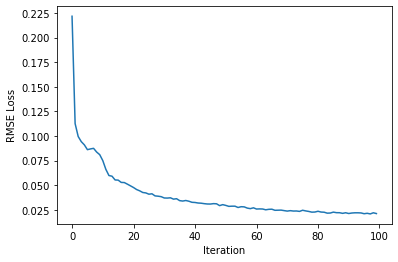

In [87]:
cum = 100
plt.xlabel("Iteration")
plt.ylabel("RMSE Loss")
plt.plot([sum(lh[i:i+cum])/cum for i in range(0, len(lh), cum)])

In [88]:
print("Iter: {} | Min: {:.4f} | Max: {:.4f} | Last: {:.4f} | Ave: {:.4f}".format(
    len(lh), min(lh), max(lh), lh[-1], sum(lh)/len(lh)))

Iter: 10000 | Min: 0.0126 | Max: 0.3173 | Last: 0.0150 | Ave: 0.0390


## Evaluate

In [92]:
model.eval()
with torch.no_grad():
    test_data = Dataset.split_item(
        test_df[["n_pm25", "n_temp", "n_humidity", "time_delta"]].values.tolist().copy())
    test_pred = model(test_data[0].view(1, -1, 4), None)[0].flatten()

print("RMSE loss:", criterion(test_pred.flatten(), test_data[1].flatten()).item())

RMSE loss: 0.014824751764535904


In [ ]:
np.round

In [96]:
test_df["pred_n_pm25"] = [float(test_data[0].flatten()[0])] + test_pred.flatten().tolist()
test_df["pred_pm25"] = scaler.inverse_transform(test_df[["n_temp", "n_humidity", "pred_n_pm25"]])[:, 2].round(2)
test_df.head(3)

,temp,humidity,pm25,monthday,weekday,hour,air_quality,datetime,time_delta,n_temp,n_humidity,n_pm25,pred_n_pm25,pred_pm25
50446,301.33,70,47.23,13,Wenesday,15,Unhealthy,2021-10-13 15:14:16,0.033333,0.342018,0.683333,0.081879,0.081879,47.23
50447,301.33,70,47.45,13,Wenesday,15,Unhealthy,2021-10-13 15:18:47,0.075278,0.342018,0.683333,0.082267,0.090653,52.21
50448,301.33,69,48.63,13,Wenesday,15,Unhealthy,2021-10-13 15:32:05,0.221667,0.342018,0.666667,0.084347,0.087547,50.45


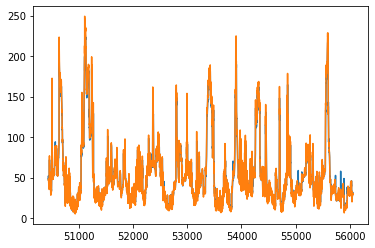

In [97]:
plt.plot(test_df.pred_pm25)
plt.plot(test_df.pm25)

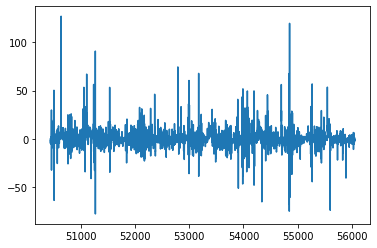

In [99]:
plt.plot(test_df.pm25 - test_df.pred_pm25)

Taking a closer look

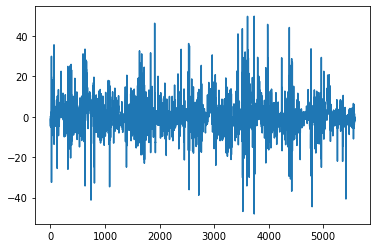

In [101]:
plt.plot([x for x in test_df.pm25 - test_df.pred_pm25 if -50 < x < 50])

(array([8.000e+00, 8.000e+00, 6.900e+01, 4.495e+03, 9.630e+02, 4.200e+01,
        1.400e+01, 4.000e+00, 1.000e+00, 2.000e+00]),
 array([-77.93 , -57.418, -36.906, -16.394,   4.118,  24.63 ,  45.142,
         65.654,  86.166, 106.678, 127.19 ]),
 <a list of 10 Patch objects>)

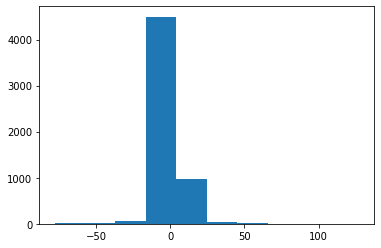

In [100]:
plt.hist(test_df.pm25 - test_df.pred_pm25)